### **Import Libraries**

In [71]:
import torch 
from datasets import load_dataset 
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset
import warnings
from functools import partial
from datasets import concatenate_datasets, DatasetDict
from functools import partial 
from IPython.display import display
from IPython.display import Markdown
import textwrap
from transformers import pipeline
from trl import SFTTrainer
# Filter out the specific warning
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')

#### **Plotting**

In [72]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')
from matplotlib import font_manager 
locations =  './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-Light.ttf


#### **Key Parameters**

In [73]:
# This cell is tagged with `parameters`
model_name = 'distilbert-base-cased'
data_link = 'ppower1/instrument'
casusal_variable = False 
column = 'text'
num_epochs = 3
seed = 2 
test_size = 0.5
max_tokens = 512

#### **Helper Functions**

In [74]:
def tokenize_function(examples, column='text'):
    return tokenizer(examples[column], truncation=True, max_length=max_tokens)

def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}

def count_tokens_truncated(example):
    tokens = tokenizer.tokenize(example['text'], truncation=True, max_length=max_tokens)
    return {"num_tokens": len(tokens)}


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### ---         Memory Check
def Memory():
    print("Current memory usage:")
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
### ---

def add_is_train_column(batch):
    # Length of the batch
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    # Create a list with the same value for all elements in the batch
    batch['is_train'] = [1] * batch_size
    return batch

# Modify the function for the test set
def add_is_test_column(batch):
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    batch['is_train'] = [0] * batch_size
    return batch

def remove_substring(example):
    # The string to be removed
    substring1 = "True or False: The Right to Counsel is in effect in the tenant's zip code."
    substring2 = "True or False: The tenant has legal representation."
    # Replace the substring with an empty string
    example["text"] = example["text"].replace(substring1, "")
    example["text"] = example["text"].replace(substring2, "")

    try:
        example["treated text"] = example["treated text"].replace(substring1, "")
        example["treated text"] = example["treated text"].replace(substring2, "")
        example["control text"] = example["control text"].replace(substring1, "")
        example["control text"] = example["control text"].replace(substring2, "")
    
    except KeyError as e:
        assert casusal_variable == False 


    return example

### ---         Print Markdown
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))
### ---

#### **Model**

In [75]:
Memory()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)
Memory()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Current memory usage:
Allocated: 1.2 GB
Cached:    11.8 GB
Current memory usage:
Allocated: 1.2 GB
Cached:    11.8 GB


#### **Load Data**

In [76]:
# Load Dataset 
original_dataset = load_dataset(data_link)['train']
original_dataset

Dataset({
    features: ['text', 'treated text', 'control text', 'raw_label', 'label'],
    num_rows: 9797
})

In [77]:
def check_prefix(example):
    example['status'] = 1 if example['text'].startswith('Yes') else 0
    return example

def filter_status(example):
    return example['status'] == 1

# Apply the function using map
# original_dataset = original_dataset.map(check_prefix)
# original_dataset = original_dataset.filter(filter_status)
original_dataset = original_dataset.shuffle(seed=42).select(range(1000))
original_dataset = original_dataset.select_columns(['text', 'label'])
original_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

#### **Compute Token Length**

In [78]:
num_tokens = original_dataset.map(count_tokens)['num_tokens']
maximum_length = max(num_tokens)
print(f'Max Length:  {maximum_length}')

num_tokens_truncated = original_dataset.map(count_tokens_truncated)['num_tokens']
maximum_length_truncated = max(num_tokens_truncated)
print(f'Max Length Truncated:  {maximum_length_truncated}')

Max Length:  706
Max Length Truncated:  512


#### **Tokens Count**

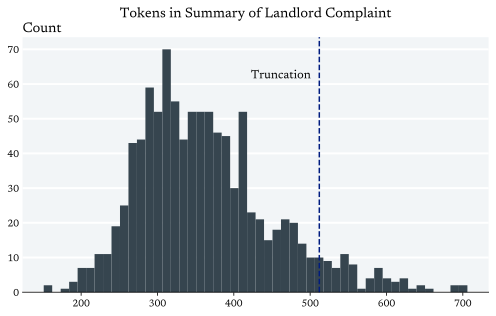

In [79]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
ax.set_title('Tokens in Summary of Landlord Complaint', size=14, loc='center', pad=20)

plt.hist(num_tokens, bins=50, color='#36454F')
plt.axvline(512, linestyle='--')
ax.annotate(f'Truncation',
                xy = (0.49, 0.85),
                xycoords='axes fraction',
                ha='left',
                va="center", 
                size=12)
plt.show()

#### **Clean Data**

In [80]:
# Shuffle the dataset
original_dataset = original_dataset.shuffle(seed=3)
#original_dataset = original_dataset.shuffle(seed=42).select(range(1000))

# Remove Unnecessary Trailing String
original_dataset = original_dataset.map(remove_substring)
print(original_dataset)


Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})


#### **Train Test Split**

In [81]:
# Split Data Set
dataset = original_dataset.train_test_split(test_size=test_size, seed=seed)

# Tokenize Dataset 
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [82]:
mt = [len(tokenized_dataset["train"][i]['input_ids']) for i in range(500)]
np.max(np.array(mt))

512

#### **Hyperparameters**

In [83]:
metric = evaluate.load("accuracy")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size= 32,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        load_best_model_at_end=True,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        #lr_scheduler_type='' #  https://stackoverflow.com/questions/77792137/how-to-fix-the-learning-rate-for-huggingface%C2%B4s-trainer
)

#### **Evaluate Initial Training Loss**

In [84]:
# To get the initial training loss
trainer = Trainer(model=model,
                args=get_training_args("test_trainer"),
                train_dataset=tokenized_dataset["train"],
                eval_dataset=tokenized_dataset["train"],
                compute_metrics=compute_metrics,
                data_collator=data_collator
)

init_train_eval = trainer.evaluate()
init_train_loss = init_train_eval['eval_loss']
init_train_accuracy = init_train_eval['eval_accuracy']
print(f"Initial Training Loss: {init_train_loss:.4f}    |   Initial Training Accuracy: {init_train_accuracy:.4f}")

Initial Training Loss: 0.5985    |   Initial Training Accuracy: 0.9480


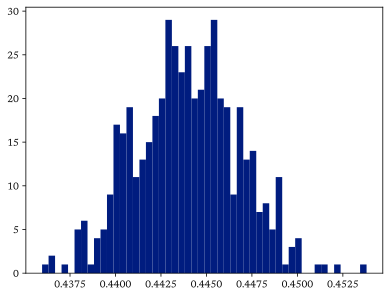

In [85]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_dataset['train']).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()
plt.hist(original_predictions, bins=50)
plt.show()

In [92]:
from datasets import Dataset

# Example data
fake_data = {'text': ["I want to go to the beach", "Lebron James is a basketball player"]}
fake_dataset = Dataset.from_dict(fake_data)

# Tokenize dataset
fake_tokenized_dataset = fake_dataset.map(tokenize_function)


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [93]:
with torch.no_grad():
    original_predictions = trainer.predict(fake_tokenized_dataset).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()
    print(original_predictions)


[0.47334614 0.44773766]


#### **Evaluate Initial Validation Loss**

In [63]:
# Actual Trainer
model.eval()
trainer = Trainer(
                model=model,
                args=get_training_args('output_dir'),
                train_dataset=tokenized_dataset["train"],
                eval_dataset=tokenized_dataset["test"],
                compute_metrics=compute_metrics,
                data_collator=data_collator,
                tokenizer=tokenizer,
)

init_eval_eval = trainer.evaluate()
init_eval_loss = init_eval_eval['eval_loss']
init_eval_accuracy = init_eval_eval['eval_accuracy']
print(f"Initial Evaluation Loss: {init_eval_loss:.4f}    |   Initial Evaluation Accuracy: {init_eval_accuracy:.4f}")

Initial Evaluation Loss: 0.3320    |   Initial Evaluation Accuracy: 0.9560


In [64]:
# Train
model.train()
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.280300,0.180720,0.956000


TrainOutput(global_step=48, training_loss=0.23035258054733276, metrics={'train_runtime': 37.4768, 'train_samples_per_second': 40.025, 'train_steps_per_second': 1.281, 'total_flos': 196287707564736.0, 'train_loss': 0.23035258054733276, 'epoch': 3.0})

In [65]:
steps, train_loss = [0] + [i['step'] for i in trainer.state.log_history if 'loss' in i], [init_train_loss] + [i['loss'] for i in trainer.state.log_history if 'loss' in i]
_, eval_loss = [i['step'] for i in trainer.state.log_history if 'eval_loss' in i], [init_eval_loss] + [i['eval_loss'] for i in trainer.state.log_history if 'eval_loss' in i]
eval_accuracy = [init_eval_accuracy] + [i['eval_accuracy'] for i in trainer.state.log_history if 'eval_accuracy' in i]
lr = [i['learning_rate'] for i in trainer.state.log_history if 'learning_rate' in i]

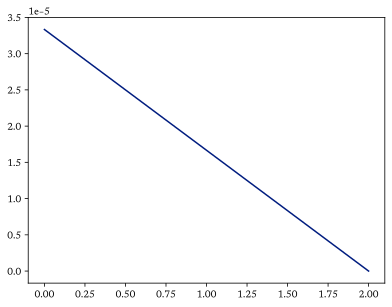

In [66]:
plt.plot(lr)
plt.show()

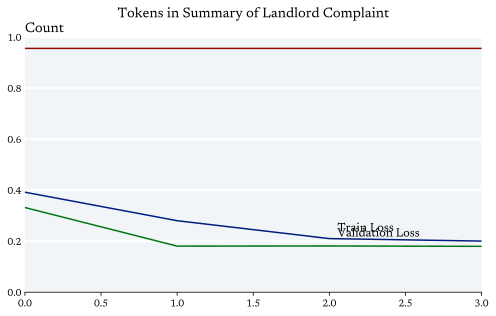

In [67]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
ax.set_title('Tokens in Summary of Landlord Complaint', size=14, loc='center', pad=20)

plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation loss')
plt.plot(eval_accuracy, label='Accuracy')

# Annotating each line at its last data point
x_positions = len(train_loss) -2  # Assuming all lists have the same length
y_pos_shift = 0.05

ax.annotate(f'Accuracy',
            xy=(x_positions, eval_accuracy[-1] + y_pos_shift),
            xytext=(8, 0),  # Shift text to right slightly
            textcoords='offset points',
            va="center", 
            ha='left',
            size=12)

ax.annotate(f'Train Loss',
            xy=(x_positions, train_loss[-1] + y_pos_shift),
            xytext=(8, 0),
            textcoords='offset points',
            va="center", 
            ha='left',
            size=12)

ax.annotate(f'Validation Loss',
            xy=(x_positions, eval_loss[-1] + y_pos_shift),
            xytext=(8, 0),
            textcoords='offset points',
            va="center", 
            ha='left',
            size=12)
plt.xlim(0, num_epochs)
plt.ylim(0, 1)
plt.show()

In [68]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_dataset['test']).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()

In [69]:
tokenizer.decode(tokenized_dataset['train']['input_ids'][0])

"[CLS] No, the Right to Counsel is not in effect in the tenant's zip code. This is a summary of a housing court complaint filed by Ansonia Acquisitions I, LLC, doing business as Woodcliff Estates, against Naomi Robles and Matthew Rodriguez. The complaint states that on October 19, 2021, the plaintiff and defendants entered into a written lease for the property located at [ ADDRESS ], Apt. 217, East Hartford, CT XXXXX. The monthly rent was set at $ 1, 227. 00, payable on the first day of each month. The defendants took possession of the premises and are still occupying it. However, they have failed to pay the rent for the months of January 2022 and February 2022. On March 1, 2022, the plaintiff served a notice, along with a Right to Counsel Notice in both English and Spanish, to the defendants, instructing them to vacate the premises by March 6, 2022, as required by law. A copy of the notice is attached to the complaint as Exhibit A. Despite the expiration of the notice period, the defe

In [70]:
original_predictions

array([0.04474375, 0.04653937, 0.04642094, 0.04415533, 0.04544427,
       0.04581755, 0.04391892, 0.04544066, 0.04450342, 0.0456029 ,
       0.04439504, 0.04435499, 0.04583484, 0.04450011, 0.04611803,
       0.04622666, 0.04327955, 0.04352991, 0.04520961, 0.0436811 ,
       0.04459862, 0.04278289, 0.04414171, 0.0467986 , 0.04374162,
       0.04587233, 0.04614417, 0.04377484, 0.04419716, 0.04551947,
       0.04547046, 0.04460008, 0.04645116, 0.04565825, 0.04416271,
       0.04439486, 0.04563937, 0.04673916, 0.04448501, 0.04329768,
       0.04376753, 0.04484425, 0.04401555, 0.04439934, 0.0448799 ,
       0.04410207, 0.04247871, 0.04583584, 0.04526999, 0.04468399,
       0.04509551, 0.04376638, 0.0446676 , 0.04356777, 0.04722111,
       0.04454385, 0.04396244, 0.04471666, 0.04590857, 0.04631936,
       0.04595213, 0.044515  , 0.04579144, 0.04358057, 0.04407935,
       0.04437974, 0.04384591, 0.04539775, 0.0436892 , 0.04502564,
       0.04368875, 0.04416353, 0.04613923, 0.04291943, 0.04662

In [ ]:
plt.hist(original_predictions, bins=20)
plt.xlim(0, 0.2)
plt.show()

#### **Clean Up**

In [ ]:
!rm -rf ./output_dir

In [ ]:
!rm -rf ./synth_evict/